# Experimenting with spatial clustering algorithms for ray detection

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import sklearn.cluster
import mpmath

from ray_delay.noise_model_patch import NoiseModelPatch
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

from mpl_toolkits.axes_grid1 import make_axes_locatable

import qc_utils.plot as plot_utils

In [2]:
dx = 7
dz = 15
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

(<Axes: >, None)

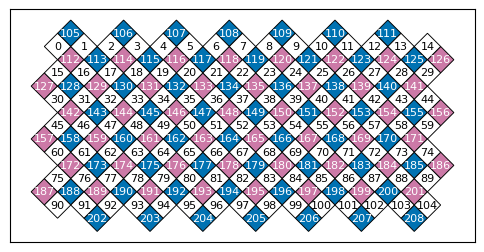

In [3]:
patch.patch.plot_qubit_vals(font_size=8)

In [4]:
ray_radius = 6
spectator_patch_data_qubits = []
ray_patch_data_qubits = []
for row in range(7):
    for col in range(15):
        idx = row*15 + col
        if col < 7:
            spectator_patch_data_qubits.append(idx)
        elif col > 7:
            ray_patch_data_qubits.append(idx)

# Getting baseline and cosmic-ray-induced detector fractions

In [5]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [6]:
patch.reset()
baseline_fracs, baseline_samples, _ = patch.patch.count_detection_events(10**6, return_full_data=True)
baseline_fractions = np.mean(baseline_fracs, axis=0)

patch.force_cosmic_ray(55, ray_radius)
patch.force_cosmic_ray(90, ray_radius)
ray_fracs, ray_samples, _ = patch.patch.count_detection_events(10**6, return_full_data=True)
ray_fractions = np.mean(ray_fracs, axis=0)

In [7]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_54861/2592127919.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


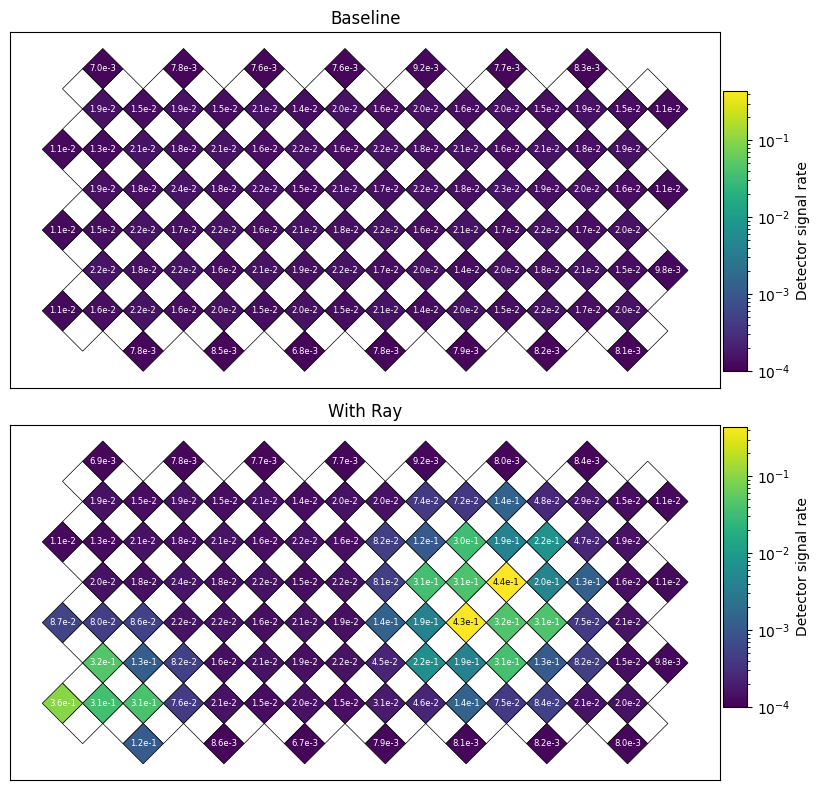

In [8]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-4
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots(2,1, figsize=(8,8))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = baseline_fractions[i]
_, cbar0 = patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[0], font_size=6, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap, cbar_kwargs={'size':0.03, 'pad':1.3})
ax[0].set_title('Baseline')
cbar0.set_label('Detector signal rate')

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
_, cbar1 = patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[1], font_size=6, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap, cbar_kwargs={'size':0.03, 'pad':1.3})
# ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax[1].set_title('With Ray')
cbar1.set_label('Detector signal rate')

plt.tight_layout()
# plt.savefig('longpatch_ray.png', dpi=300)

# Running DBSCAN over many trials

In [9]:
temporal_distance = 6*dm
ntrials = 1

rng = np.random.default_rng(1)

In [10]:
detector_thresholds = np.zeros(baseline_fractions.shape, int)
for q,frac in enumerate(baseline_fractions):
    detector_thresholds[q] = scipy.stats.binom.ppf(1-1e-6, temporal_distance, frac)

/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:90: RuntimeWarning: overflow encountered in _binom_ppf
  return _boost._binom_ppf(q, n, p)


In [11]:
selected_qubits = np.zeros((ntrials, temporal_distance, len(patch.patch.all_qubits)), bool)
dbscan_labels = np.full((ntrials, temporal_distance, len(patch.patch.all_qubits)), -1)
all_qubit_coords = [[] for _ in range(ntrials)]

dbscan = sklearn.cluster.DBSCAN(eps=1, min_samples=5)

for trial in range(ntrials):
    baseline_indices = rng.choice(baseline_samples.shape[0], size=temporal_distance, replace=False)
    baseline_detector_counts = np.sum(baseline_samples[baseline_indices], axis=1)
    ray_indices = rng.choice(ray_samples.shape[0], size=temporal_distance, replace=False)
    ray_detector_counts = np.sum(ray_samples[ray_indices], axis=1)

    detector_counts = np.concatenate((baseline_detector_counts, ray_detector_counts), axis=0)
    for latency in range(temporal_distance):
        detector_sums = np.sum(detector_counts[latency:latency+temporal_distance], axis=0)
        selected_detectors = (detector_sums > detector_thresholds)
        qubits = []
        qubit_coords = []
        for j,q in enumerate(patch.patch.get_syndrome_qubits()):
            selected_qubits[trial, latency, q.idx] = selected_detectors[j]
            if selected_detectors[j]:
                qubits.append(q.idx)
                qubit_coords.append([q.coords[0] // 2, q.coords[1] // 2])
        all_qubit_coords[trial].append(qubit_coords)
        if len(qubit_coords) > 0:
            clustered_data = dbscan.fit(qubit_coords)
            labels = clustered_data.labels_
            for j,q in enumerate(patch.patch.get_syndrome_qubits()):
                if q.idx in qubits:
                    dbscan_labels[trial, latency, q.idx] = labels[qubits.index(q.idx)]
                else:
                    dbscan_labels[trial, latency, q.idx] = -1

In [ ]:
import timeit
result = timeit.timeit(lambda: dbscan.fit_predict(qubit_coords), number=10000)
result / 10000

0.0007511363290948793

/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/stim_surface_code/patch.py:1464: RuntimeWarning: invalid value encountered in scalar divide
  qubit_color_dict[i] = cmap((val-vmin)/(vmax-vmin))
/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/stim_surface_code/patch.py:1464: RuntimeWarning: invalid value encountered in scalar divide
  qubit_color_dict[i] = cmap((val-vmin)/(vmax-vmin))


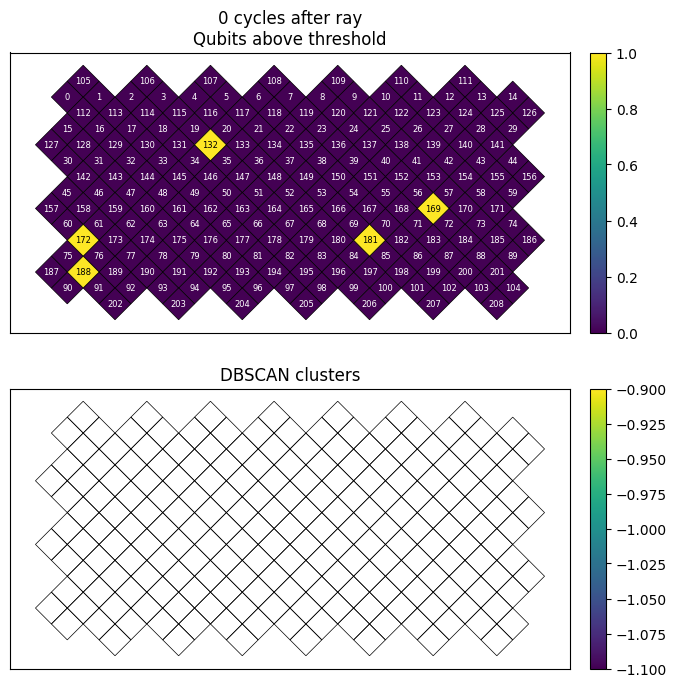

In [ ]:
from matplotlib.animation import FuncAnimation

fig,ax = plt.subplots(2,1, figsize=(8,8))

_, cbar0 = patch.patch.plot_qubit_vals(qubit_vals=selected_qubits[0,0].astype(int), ax=ax[0], font_size=6, cbar_kwargs={'size':0.02, 'pad':1.0})
ax[0].set_title(f'{i} cycles after ray\nQubits above threshold')

_, cbar1 = patch.patch.plot_qubit_vals(qubit_vals=dbscan_labels[0,0], ax=ax[1], font_size=6, cbar_kwargs={'size':0.02, 'pad':1.0})
ax[1].set_title('DBSCAN clusters')

def update(i):    
    ax[0].clear()
    ax[1].clear()
    # cbar0.remove()
    # cbar1.remove()

    patch.patch.plot_qubit_vals(qubit_vals=selected_qubits[0,i].astype(int), ax=ax[0], font_size=6, cbar=cbar0)
    ax[0].set_title(f'{i} cycles after ray\nQubits above threshold')

    patch.patch.plot_qubit_vals(qubit_vals=dbscan_labels[0,i], ax=ax[1], font_size=6, cbar=cbar1)
    ax[1].set_title('DBSCAN clusters')

    return ax

anim = FuncAnimation(fig, update, frames=range(temporal_distance), interval=500)
anim.save(f'../figures/DBSCAN.gif')

If DBSCAN ends up being too slow, the alternative is to run the simple windowing
algorithm to make a fast decision, then use DBSCAN afterwards to refine decision
and possibly add spectator patches back in.

## Creating a faster custom DBSCAN

We can speed things up a lot since our data is held in a Numpy array (and is not
just a list of coordinates)

In [ ]:
def get_neighbors(mat, row, col):
    return mat[max(row-1,0):min(row+2,mat.shape[0]), max(col-1,0):min(col+2,mat.shape[1])]

def count_neighbors(mat, row, col):
    return np.sum(mat[max(row-1,0):min(row+2,mat.shape[0]), max(col-1,0):min(col+2,mat.shape[1])])

In [ ]:
def my_dbscan(point_coords, point_idx_array, min_pts):
    labels = np.full(len(point_coords), -2)
    cluster_label = 0
    for i,coords in enumerate(point_coords):
        if labels[i] != -2:
            continue
        neighbors = get_neighbors(point_idx_array, coords[0], coords[1])
        neighbors = neighbors[neighbors != -1]
        num = neighbors.shape[0] - 1
        if num < min_pts:
            labels[i] = -1
            continue
        labels[i] = cluster_label
        seed_set = set(neighbors)
        while len(seed_set) > 0:
            seed_idx = seed_set.pop()
            if labels[seed_idx] == -1:
                labels[seed_idx] = cluster_label
                continue
            if labels[seed_idx] != -2:
                continue
            labels[seed_idx] = cluster_label

            # could probably vectorize this part more to make it even faster
            seed_neighbors = get_neighbors(point_idx_array, point_coords[seed_idx][0], point_coords[seed_idx][1])
            seed_neighbors = set(seed_neighbors[seed_neighbors != -1])
            if len(seed_neighbors) >= min_pts:
                seed_set.update(seed_neighbors)
        cluster_label += 1
    return labels

In [ ]:
time_idx = 4

In [ ]:
qubit_coords = all_qubit_coords[0][time_idx]

device = np.zeros((int(np.ceil(len(patch.patch.device)/2)), int(np.ceil(len(patch.patch.device[0])/2))), bool)
for coords in qubit_coords:
    device[coords[0], coords[1]] = True

device_indices = np.full(device.shape, -1, int)
for i,coords in enumerate(qubit_coords):
    device_indices[coords[0], coords[1]] = i

In [ ]:
device_indices

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, 14,  1, 15, -1, -1],
       [-1,  2, 16, -1, -1, -1, -1, -1, 17,  3, 18,  4, 19,  5, -1, -1],
       [-1, 20,  6, -1, -1, -1, -1, -1,  7, 21,  8, 22,  9, 23, -1, 24],
       [25, 10, 26, -1, -1, -1, -1, -1, -1, -1, 27, -1, -1, 11, -1, -1],
       [-1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [ ]:
timeit.timeit(lambda: my_dbscan(qubit_coords, device_indices, 5), number=10000)/10000

0.00017328615409787745

In [ ]:
labels = my_dbscan(qubit_coords, device_indices, 3)

device_label = np.full(device.shape, -1, int)
for i,coords in enumerate(all_qubit_coords[0][time_idx]):
    device_label[coords[0], coords[1]] = labels[i]

In [ ]:
device_label

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1, -1],
       [ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1],
       [-1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])